# Imports

In [4]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import sys
import networkx as nx
import misc
import math
import random
import time
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import DcOrientRandomSimple
import DcSimple
import StaticSimple

# Data Generation

In [2]:
G = misc.createRandomGraph(size=100, variation=0, density=0.5)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 100
Edges: 2475
Density: 0.5
Max Degree: 60
Average Degree: 49.5
Static Coloring uses 20 colors


4.12

In [3]:
# EITHER
updates = misc.extractUpdates(G, 'random')

Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

In [118]:
# OR
updates = misc.extractStream(G, 10000, addProb=0.5, ordering='timeout')

Ge = G.copy()

In [4]:
# Ge = nx.Graph()
# Ge.add_nodes_from(list(G.nodes()))

# Algorithm Preparation

In [119]:
experimentList = []

experimentList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 1'])
experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])

d = 10
experimentList.append([SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10])

d = 10
experimentList.append([BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10])

l = 10
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

l = 50
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

l = 5
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])

l = 50
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])

p=0.998
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])

p=0.8
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])

experimentList.append([DcOrient.DcOrientAlgo(Ge), 'DC-Orient'])


# Experimenting

In [120]:
# CSV Writer
loadingBar = True
f = open('experiment_output.csv', 'w', newline='')
writer = csv.writer(f)

print('Graph used in the experiment:')
misc.graphInfo(G)

row = [str(G.number_of_nodes()) + ' Nodes; ' + str(G.number_of_edges()) + ' Edges; C = ' + str(misc.numberOfColors(nx.coloring.greedy_color(G))),'Average nr. of Recolors', 'Total nr. of Colors', 'Time Taken (s)']
writer.writerow(row)

for experiment in experimentList:

    row = [str(experiment[1])]

    if len(experiment) == 3:
        random.seed(experiment[2])
    else:
        random.seed()

    print("")
    print("------------------------------------------------------------------")
    print(str(experiment[1]) + ":")
    iterator = misc.UpdateIterator(experiment[0], updates)

    recolors = 0
    timer = time.perf_counter()

    totalUpdates = len(updates)
    done = 0
    barLength = 64

    if loadingBar:
        #line to be overwritten
        print("")

    while True:
        
        if loadingBar:
            #overwrite previously printed line
            percentageDone = int(done/totalUpdates*barLength)
            b = ("[" + percentageDone * "+" + (barLength - percentageDone) * "-" + "]")
            sys.stdout.write('\r'+b)
            sys.stdout.flush()

        if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
            raise ValueError('The coloring produced is incorrect')
        c1 = iterator.algo.getColoring()
        if iterator.runUpdate(1):
            c2 = iterator.algo.getColoring()
            recolors += misc.numberOfRecolors(c1, c2)
            done += 1
        else:
            #print("all updates finished")
            break

    timer = time.perf_counter() - timer

    if loadingBar:
        #overwrite previously printed line
        b = ("")
        sys.stdout.write('\r'+b)
        sys.stdout.flush()

    avgColors = float(recolors)/len(updates)
    b = "Average number of recolors per update: " + str(avgColors)
    b = b + (barLength + 2 - len(b)) * " "
    print(b)
    row.append(str(round(avgColors, 2)))
    totColors = misc.numberOfColors(iterator.algo.getColoring())
    print("Total number of colors used at the end: " + str(totColors))
    row.append(str(totColors))
    print("Time taken : " + str(timer) + " seconds")
    row.append(str(round(timer, 3)))
    #print("Average elementary operations : " + str(iterator.avgElemCounter))
    print("------------------------------------------------------------------")
    writer.writerow(row)

print("End of experiment list reached")
f.close()


Graph used in the experiment:
Nodes: 200
Edges: 9950
Density: 0.5
Max Degree: 118
Average Degree: 99.5
Static Coloring uses 34 colors

------------------------------------------------------------------
Random Warm-Up 1:

Average number of recolors per update: 0.0116                     
Total number of colors used at the end: 107
Time taken : 42.052701000000525 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up 2:

Average number of recolors per update: 0.0207                     
Total number of colors used at the end: 99
Time taken : 42.66434409999965 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 10):

Average number of recolors per update: 2.2241                     
Total number of colors used at the end: 83
Time taken : 47.90382859999954 seconds
-------

# Results

In [9]:
coordinateList

[[[0.05651243949116289, 132]],
 [[0.1579421366655409, 133]],
 [[0.375548801080716, 134],
  [2.6118428458853993, 123],
  [2.962174940898345, 127],
  [3.3030507711358776, 128],
  [3.614432061240572, 123],
  [3.5671507373635034, 123],
  [3.566587864460205, 123],
  [4.127884723629404, 128],
  [4.096814139367331, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128],
  [4.094562647754137, 128]],
 [[19.65585950692334, 117],
  [9.455026455026456, 118],
  [6.189913317572892, 121],
  [5.091635708656986, 125],
  [4.700326

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_18360\2360589337.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


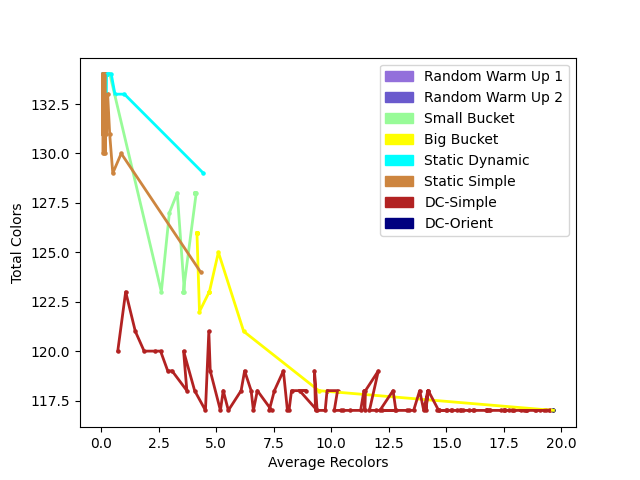

In [13]:
from scipy.ndimage.filters import gaussian_filter1d
plt.close()

algoNames = ['Random Warm Up 1', 'Random Warm Up 2', 'Small Bucket', 'Big Bucket', 'Static Dynamic', 'Static Simple', 'DC-Simple', 'DC-Orient']
colorDict = matplotlib.colors.CSS4_COLORS
colors = [colorDict.get('mediumpurple'), colorDict.get('slateblue'), colorDict.get('palegreen'), colorDict.get('yellow'), colorDict.get('cyan'), colorDict.get('peru'), colorDict.get('firebrick'), colorDict.get('navy')]
patches = []

j = 0
for list in coordinateList:
    color = colors[j]
    patch = matplotlib.patches.Patch(color=color, label=algoNames[j])
    patches.append(patch)
        
    xcoords = [i[0] for i in list]
    ycoords = [i[1] for i in list]

    # Smoothed line plot
    ysmoothed = gaussian_filter1d(ycoords.copy(), sigma=2)
    #plt.plot(xcoords, ysmoothed, c=color, linewidth=3)

    # Original line plot
    plt.plot(xcoords, ycoords, c=color, linewidth=2)

    # Points plot
    plt.scatter(xcoords, ycoords, c=color, s=5)

    j += 1
plt.xlabel("Average Recolors")
plt.ylabel("Total Colors")
plt.legend(handles=patches)
plt.show()